In [1]:
import numpy as np

from modules.helper_functions_tsp import ( 
    read_file_name, validate_distance_array, find_problem_size, cost_fn_fact, 
    read_index, hot_start, convert_bit_string_to_cycle, hot_start_list_to_string,
    update_parameters_using_gradient, define_parameters, create_initial_rotations,
    bind_weights, vqc_circuit, cost_func_evaluate)

from modules.graph_functions import parameter_graph, cost_graph_multi

import copy

In [2]:
from modules.config import (
    CONTROL_FILE, ENCODING, GRAPH_DIRECTORY, LOCATIONS, ROTATIONS, SHOTS,
    AVERAGE_SLICE, MODE, ITERATIONS, PRINT_FREQUENCY, GRAY, HOT_START,
    VERBOSE, GRADIENT_TYPE, S, ETA, ALPHA, GAMMA, C,
    DATA_SOURCES)

## Read in the control file
The executions are controlled by a CSV parameter file in the control directory

In [3]:
control_dict = read_index(CONTROL_FILE, ENCODING)
print(control_dict)

{0: {'id': '0', 'locations': '5', 'mode': '1', 'eta': '0.005', 'updates': '50', 'print_frequency': '5', 'gray': '1', 'verbose': '1', 'optimiser': 'tbc'}, 1: {'id': '1', 'locations': '5', 'mode': '2', 'eta': '0.005', 'updates': '50', 'print_frequency': '5', 'gray': '1', 'verbose': '1', 'optimiser': 'tbc'}}


From the number of locations visited find the qubits and longest binary string.

In [4]:
bin_len, qubits = find_problem_size(LOCATIONS)
print(f'There are {qubits} qubits needed.  The longest binary string is {bin_len}')

There are 5 qubits needed.  The longest binary string is 2


Data sources are held locally to avoid downstream dependencies.  Read the data, and print out the filename and best distance held in the data.

In [6]:
filename = read_file_name(LOCATIONS, DATA_SOURCES)
best_dist = DATA_SOURCES[LOCATIONS]['best']
print(f'Data will be read from filename {filename}.  It is known that the shortest distance is {best_dist}.')

Data will be read from filename data/five_d.txt.  It is known that the shortest distance is 19.


Read and validate the distance array.  This checks the array is the correct shape, and is symmetric.

In [7]:
distance_array = np.genfromtxt(filename)
validate_distance_array(distance_array, LOCATIONS)

Define the VQC circuits with appropriate parameters, and draw the circuit.

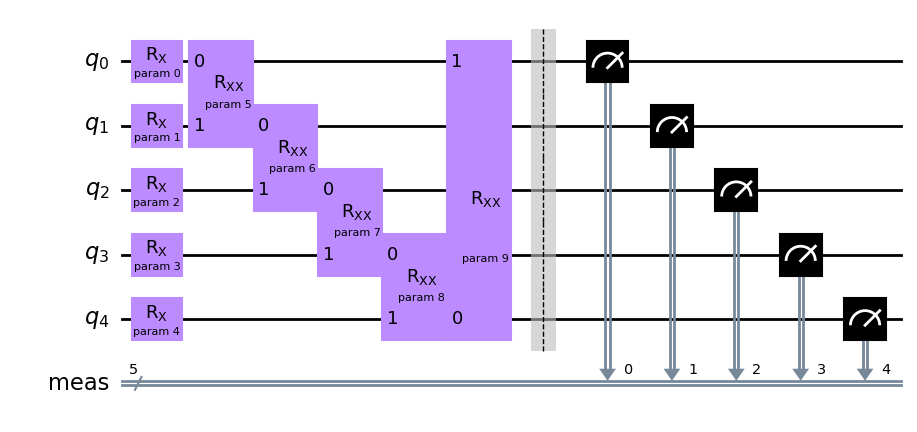

In [8]:
params = define_parameters(qubits, MODE)
qc = vqc_circuit(qubits, params, MODE)
qc.draw("mpl", style="clifford")

In [9]:
cost_fn = cost_fn_fact(LOCATIONS,distance_array, GRAY)
result = cost_fn([1, 1, 0, 1, 0])
result = cost_fn([1, 1, 0, 1, 0])
result = cost_fn([1, 1, 0, 1, 0])
#help(cost_fn)

#cost_fn.print_cache_stats


Iterate over the control parameters and do one experiment for each one of them.

Create random initial rotations, and bind these to the parameters in a new circuit `bc`.

The hot start location list is [0, 3, 2, 1, 4]
This is equivalent to a binary list: [1, 1, 0, 1, 0]
The hot start distance is 21.0, compared to a best distance of 19.
The initial parameters (weights) are [0.         3.14159265 0.         3.14159265 3.14159265 0.
 0.         0.         0.         0.        ]


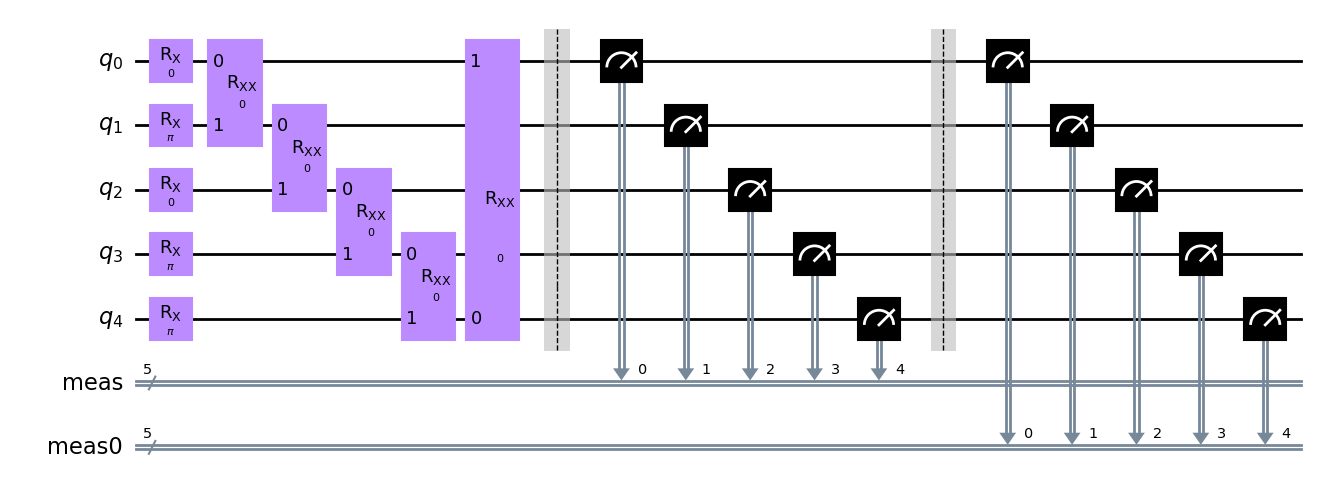

In [10]:
if HOT_START:
    hot_start_list = hot_start(distance_array, LOCATIONS)
    print(f'The hot start location list is {hot_start_list}')
    bin_hot_start_list =  hot_start_list_to_string(hot_start_list, LOCATIONS, GRAY)
    print(f'This is equivalent to a binary list: {bin_hot_start_list}')
    distance = cost_fn(bin_hot_start_list)
    print(f'The hot start distance is {distance}, compared to a best distance of {best_dist}.')
    init_rots = create_initial_rotations(qubits, MODE, bin_hot_start_list, HOT_START)
else:
    init_rots = create_initial_rotations(qubits, MODE)
print(f'The initial parameters (weights) are {init_rots}')
bc = bind_weights(params, init_rots, qc)
bc.measure_all()
bc.draw("mpl", style="clifford")

In [11]:
cost_start, lowest_to_date, _ = cost_func_evaluate(cost_fn, bc, shots=SHOTS, average_slice=AVERAGE_SLICE, verbose=VERBOSE)
print(f'For the starting circuit the average cost is {cost_start:.1f} and the lowest cost is {lowest_to_date:.1f}')

For the starting circuit the average cost is 21.0 and the lowest cost is 21.0


Next we test the impact of varying each parameter in turn on the average cost.

In [12]:
param_values = np.array([(i * 2 * np.pi) / (ROTATIONS-1) for i in range(ROTATIONS)])

In [13]:
cost_list_all, lowest_list_all, sliced_cost_list_all = [], [], []
if VERBOSE:
    print(f'init_rots = {init_rots}')
#need deep copy in case init_rots is changed
for i in range(2*qubits):
    rots = copy.deepcopy(init_rots)
    if VERBOSE:
        print(f'Processing parameter {i}')
        print(f'rots = {rots}, init_rots = {init_rots}')
    cost_list, lowest_list, sliced_cost_list  = [], [], []
    for angle in param_values:
        rots[i] = angle
        bc = bind_weights(params, rots, qc)
        sliced_cost, _ , _ = cost_func_evaluate(cost_fn, bc, SHOTS, average_slice=AVERAGE_SLICE, verbose=VERBOSE)
        cost, lowest, lowest_energy_bit_string = cost_func_evaluate(cost_fn, bc, SHOTS, average_slice=1, verbose=VERBOSE)
        route_list = convert_bit_string_to_cycle(lowest_energy_bit_string, LOCATIONS, gray=GRAY)
        cost_list.append(cost)
        lowest_list.append(lowest)
        sliced_cost_list.append(sliced_cost)
        if VERBOSE:
            print(f'For angle {angle} the cost is {cost}, the lowest cost found is {lowest}')
            print(f'The full parameter vector is {rots}')
            print(f'the lowest energy bit string is {lowest_energy_bit_string} and this corresponds to a route of {route_list}')
            print(f'The average is {cost} without slicing, and {sliced_cost} with slicing')
    cost_list_all.append(cost_list)
    lowest_list_all.append(lowest_list)     
    sliced_cost_list_all.append(sliced_cost_list)

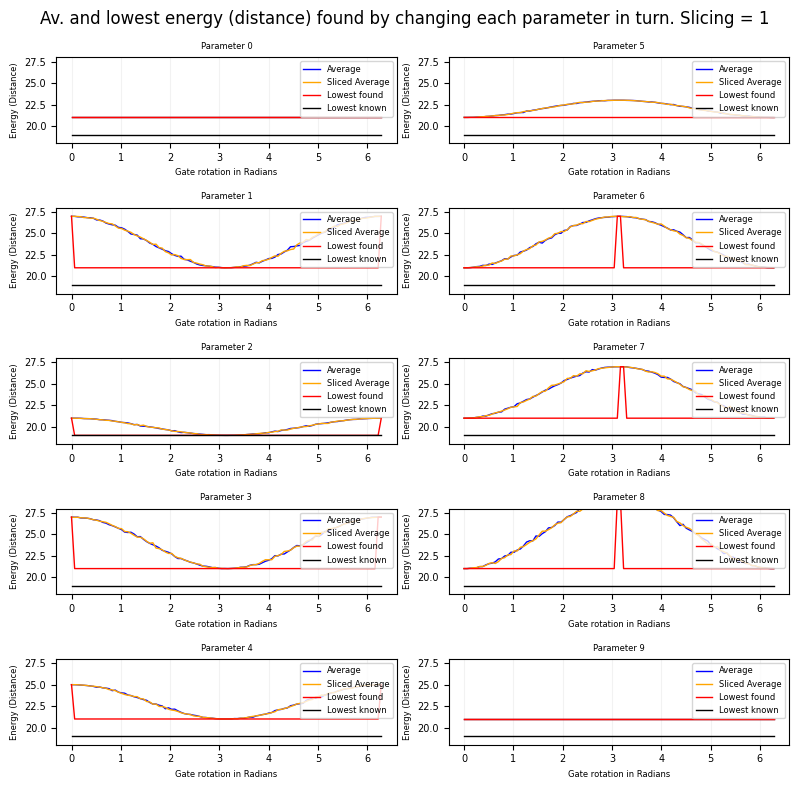

In [14]:
filename = GRAPH_DIRECTORY + 'Parameter_values'
main_title = f'Av. and lowest energy (distance) found by changing each parameter in turn. Slicing = {AVERAGE_SLICE}'
sub_title = 'Parameter '
x_label = 'Gate rotation in Radians'
param_names = [i for i in range(2*qubits)]
cost_graph_multi(filename, param_names, param_values, 
                 cost_list_all, lowest_list_all, sliced_cost_list_all, 
                 best_dist, main_title, sub_title, x_label)

In [15]:
cost_fn.print_cache_stats

Items in cache = 11
cache_hit = 3899
cache_miss = 11
cache_hit_rate = 0.997


In [16]:
index_l, sliced_l, lowest_l, gradient_l, average_l, parameter_l = \
    update_parameters_using_gradient(locations=LOCATIONS, iterations=ITERATIONS, 
                                    print_frequency=PRINT_FREQUENCY, params=params,
                                    rots=init_rots,  
                                    cost_fn=cost_fn, qc = qc, shots=SHOTS, s=S, 
                                    eta=ETA, average_slice=AVERAGE_SLICE, gray=GRAY, 
                                    verbose=VERBOSE, gradient_type=GRADIENT_TYPE,
                                    alpha=ALPHA, gamma=GAMMA, c=C
                                    )

For iteration 0 using the best 100 percent of the results
The average cost from the sample is 21.000 and the top-sliced average of the best results is 21.000
The lowest cost from the sample is 21.000
The lowest cost to date is 21.000 corresponding to bit string [1, 1, 0, 1, 0] 
and route [0, 3, 2, 1, 4]
For iteration 5 using the best 100 percent of the results
The average cost from the sample is 24.098 and the top-sliced average of the best results is 24.160
The lowest cost from the sample is 19.000
The lowest cost to date is 19.000 corresponding to bit string [1, 1, 1, 1, 0] 
and route [0, 3, 4, 1, 2]
For iteration 10 using the best 100 percent of the results
The average cost from the sample is 23.861 and the top-sliced average of the best results is 23.789
The lowest cost from the sample is 19.000
The lowest cost to date is 19.000 corresponding to bit string [1, 1, 1, 1, 0] 
and route [0, 3, 4, 1, 2]
For iteration 15 using the best 100 percent of the results
The average cost from the

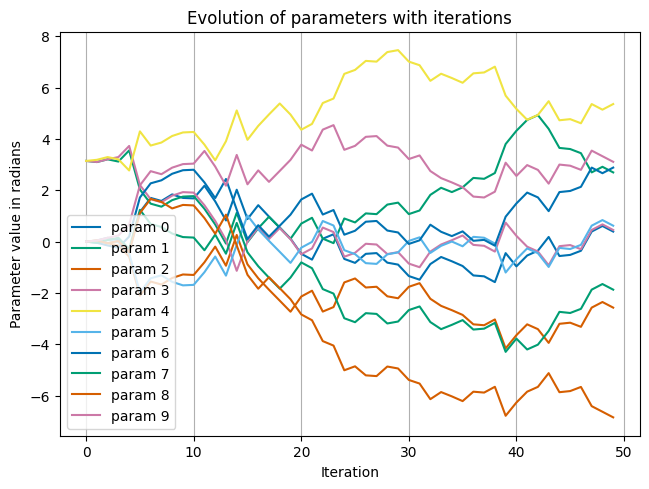

In [17]:
legend = [params[i].name for i in range(len(params))] 
filename = GRAPH_DIRECTORY+f'Evolution of parameters with iterations'
parameter_graph(filename, index_l, parameter_l, legend)

In [18]:
cost_fn.print_cache_stats

Items in cache = 32
cache_hit = 9519
cache_miss = 32
cache_hit_rate = 0.997


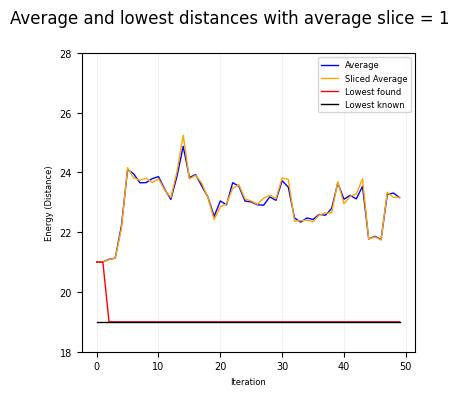

In [19]:
average_list_all = [average_l]
lowest_list_all = [lowest_l]
sliced_list_all = [sliced_l]
title = f'Average and lowest distances with average slice = {AVERAGE_SLICE}'
filename = GRAPH_DIRECTORY+title+'.png'
parameter_list = [AVERAGE_SLICE]
x_label = 'Iteration'
cost_graph_multi(filename, parameter_list, index_l, 
                 average_list_all, lowest_list_all, sliced_list_all,
                 best_dist, main_title=title, x_label=x_label, figsize = (4,4))

In [20]:
av_cost_list_all, lowest_list_all, sliced_cost_list_all = [], [], []
slices = [1, 0.75, 0.6, 0.5, 0.4, 0.25, 0.15, 0.05]
for slice in slices:
    index_list, sliced_list, lowest_list, _ , average_list, _ = \
    update_parameters_using_gradient(locations=LOCATIONS, iterations=ITERATIONS, 
                                    print_frequency=PRINT_FREQUENCY, params=params,
                                    rots=rots,  
                                    cost_fn=cost_fn, qc = qc, shots=SHOTS, s=S, 
                                    eta=ETA, average_slice=slice, gray=GRAY, 
                                    verbose=VERBOSE, gradient_type=GRADIENT_TYPE,
                                    alpha=ALPHA, gamma=GAMMA, c=C)
    av_cost_list_all.append(average_list)
    lowest_list_all.append(lowest_list)
    sliced_cost_list_all.append(sliced_list)

For iteration 0 using the best 100 percent of the results
The average cost from the sample is 21.000 and the top-sliced average of the best results is 21.000
The lowest cost from the sample is 21.000
The lowest cost to date is 21.000 corresponding to bit string [1, 1, 0, 1, 0] 
and route [0, 3, 2, 1, 4]
For iteration 5 using the best 100 percent of the results
The average cost from the sample is 21.852 and the top-sliced average of the best results is 21.754
The lowest cost from the sample is 19.000
The lowest cost to date is 19.000 corresponding to bit string [1, 1, 1, 1, 0] 
and route [0, 3, 4, 1, 2]
For iteration 10 using the best 100 percent of the results
The average cost from the sample is 22.307 and the top-sliced average of the best results is 22.543
The lowest cost from the sample is 19.000
The lowest cost to date is 19.000 corresponding to bit string [1, 1, 1, 1, 0] 
and route [0, 3, 4, 1, 2]
For iteration 15 using the best 100 percent of the results
The average cost from the

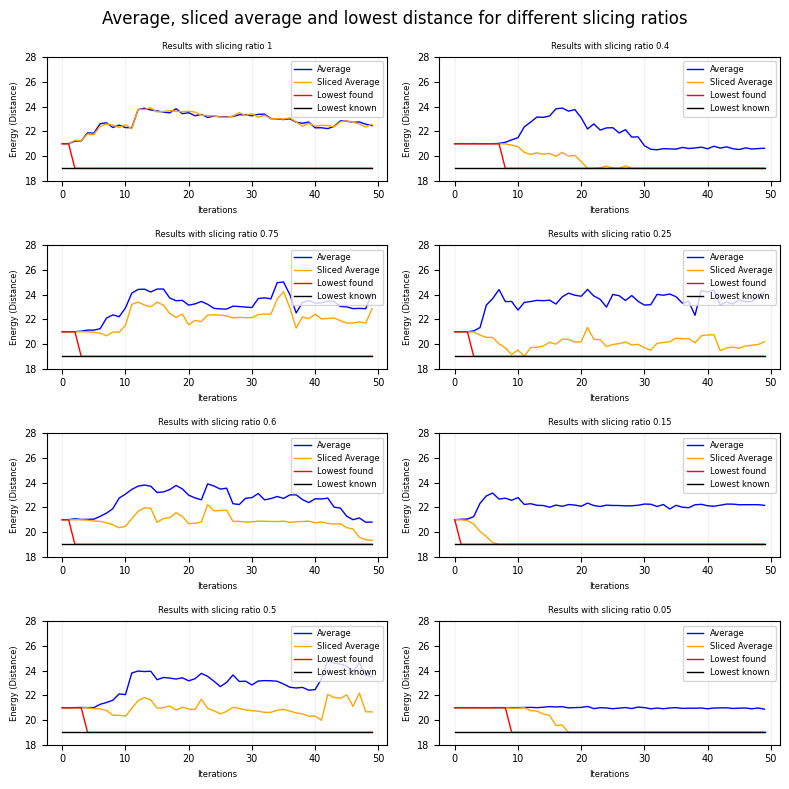

In [21]:
title = 'Average, sliced average and lowest distance for different slicing ratios'
filename = GRAPH_DIRECTORY+title+'.png'
sub_title = 'Results with slicing ratio '
x_label = 'Iterations'
cost_graph_multi(filename, slices, index_list, av_cost_list_all, 
                lowest_list_all, sliced_cost_list_all, 
                best_dist, title, sub_title,
                x_label
                )